<a href="https://colab.research.google.com/github/petroniocandido/STPE/blob/main/S%C3%A9ries_Temporais_e_Processos_Estoc%C3%A1sticos_Previs%C3%A3o_Probabil%C3%ADstica_e_Intervalar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão Probabilística e Intervalar

**Disciplina:** Tópicos Especiais - Séries Temporais e Processos Estocásticos

**Professor:** <a href="http://petroniocandido.github.io"> Petrônio Cândido de Lima e Silva</a> <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span> (petronio.candido@ifnmg.edu.br)

[![made-with-python](https://img.shields.io/badge/Made%20with-Python-1f425f.svg)](https://www.python.org/)  [![made-with-latex](https://img.shields.io/badge/Made%20with-LaTeX-1f425f.svg)](https://www.latex-project.org/) [![ForTheBadge built-with-love](http://ForTheBadge.com/images/badges/built-with-love.svg)](https://GitHub.com/Naereen/) [![ForTheBadge built-with-science](http://ForTheBadge.com/images/badges/built-with-science.svg)](https://GitHub.com/Naereen/)




<center>
  <table><tr>
<td><a href="https://ppgmcs.com.br/"><img src="https://ppgmcs.com.br/wp-content/uploads/ppgmcs.png" alt="Programa de Pós-Graduação em Modelagem Computacional e Sistemas - PPGMCS/Unimontes" height="60" width="150"/></a></td> 

 <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>

<td><a href="#"><img src="https://avatars1.githubusercontent.com/u/54992196?s=400&u=4c96d4fc0560b6957233f1dd91a9560de4a054b2&v=4" alt="{cidic} - Grupo de Pesquisa em Ciência de Dados e Inteligência Computacional" width="100"/></a></td> 

 <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
  
<td>
   <a href="http://www.ifnmg.edu.br/"><img src="https://github.com/petroniocandido/PhdThesis/raw/master/figures/ifnmg.jpg" alt="IFNMG - Instituto Federal do Norte de Minas Gerais" width="100"/></a></td>
</tr>
</table>
</center>

[![licensebuttons by-nc-sa](https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png)](https://creativecommons.org/licenses/by-nc-sa/4.0) 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dados

### Passageiros Aéreos

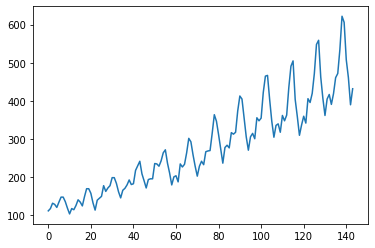

In [ ]:
st1 = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
st1 = st1['Passengers'].values

plt.plot(st1)


### Dow Jones

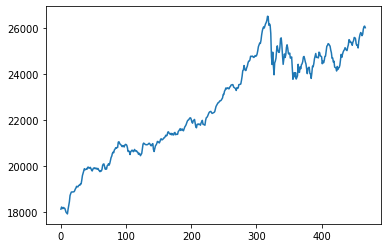

In [ ]:
st2 = pd.read_csv('https://query.data.world/s/mcwvp7zb7monq3kisbbwauo6tffapt', sep=',')
st2 = st2['AVG'].values[8000:]

plt.plot(st2)

### Códigos comuns

In [ ]:
def lags(dados, p):
  n = len(dados)
  X = np.zeros((n-p, p))
  Y = dados[p:]
  for i in range(p, n):
    X[i-p,:] = dados[i-p:i]
  return X,Y

def ajustar_ar(dados, parametros):
  p = parametros[0]
  X,Y = lags(dados, p)
  coef = np.linalg.inv(X.T.dot(X)).dot( X.T.dot(Y) )

  previsoes = ar(dados, [coef, None])
  residuos = dados[p:] - previsoes

  sigma2 = np.std(residuos)

  return coef, sigma2

def ar(dados, parametros):
  coef, sigma = parametros
  p = len(coef)
  n = len(dados)
  ret = np.zeros(n-p)
  for i in range(p,n):
    ret[i-p] = dados[i-p:i].dot(coef)

  return ret 

def ajustar_arma(dados, parametros):
  p, q = parametros
  alfa, _ = ajustar_ar(dados, [p])

  previsoes = ar(dados, [alfa, None])
  
  residuos_ar = dados[p:] - previsoes
  
  beta, _ = ajustar_ar(residuos_ar, [q])

  previsoes_ma = ar(residuos_ar, [beta, None])

  residuos_ma = residuos_ar[q:] - previsoes_ma

  sigma = np.std(residuos_ma)

  return alfa, beta, sigma

def arma(dados, parametros):
  alfa, beta, sigma = parametros
  p = len(alfa)
  q = len(beta)

  previsoes_ar = ar(dados, [alfa, sigma])
  residuos_ar = dados[p:] - previsoes_ar

  previsoes_ma = ar(residuos_ar, [beta, sigma])
  return previsoes_ar[q:] + previsoes_ma

def ajustar_es(dados, parametros):
  alfa, ordem = parametros
  previstos = es(dados, [alfa, ordem, None])
  residuos = dados[ordem:] - previstos
  sigma = np.std(residuos)
  return alfa, ordem, sigma

def es(dados, parametros):
  alfa, ordem, sigma = parametros
  n = len(dados)
  ret = np.zeros(n - ordem)
  for i in range(ordem, n):
    ret[i-ordem] = np.sum([alfa * (1 - alfa)** j * dados[i - j] for j in range(0, ordem)])
  return ret

## Previsão para muitos passos à frente (H = n)

### Abordagem Especialista

In [ ]:
def lags_H(dados, p, H=1):
  n = len(dados)
  X = np.zeros((n-p-H, p))
  Y = dados[p+H:]
  for i in range(p, n-H):
    X[i-p,:] = dados[i-p:i]
  return X,Y

def ajustar_ar_H(dados, parametros, H = 1):
  p = parametros[0]
  X,Y = lags_H(dados, p, H)
  coef = np.linalg.inv(X.T.dot(X)).dot( X.T.dot(Y) )

  previsoes = ar(dados, [coef, None])
  residuos = dados[p+H:] - previsoes[:-H]
  sigma = np.std(residuos)

  return coef, sigma



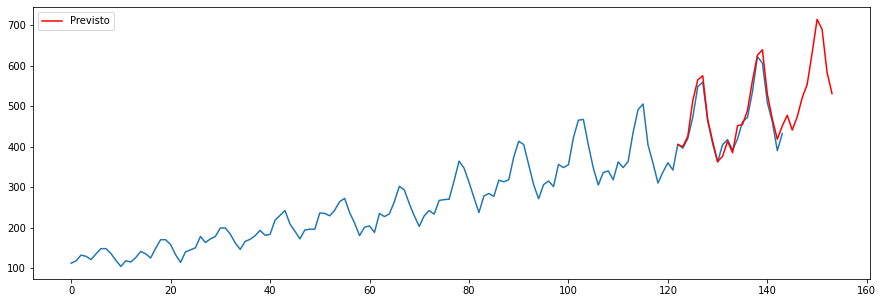

In [ ]:
H = 10
ordem = 12
amostra = st1[100:]

# Ajustar o modelo AR(p) para H = n
parametros = ajustar_ar_H(st1[:100], [12], H)

previsoes = ar(amostra, parametros)

fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(st1)
#ax.plot(range(0, len(amostra)), amostra, c='black', label='Original')
ax.plot(range(100+ordem+H, len(amostra)+H+100), previsoes, c='red', label='Previsto')

plt.legend()

### Abordagem Recursiva

In [ ]:
def ar_recursivo(dados, parametros, H=1):
  coef, sigma = parametros
  p = len(coef)
  n = len(dados)
  ndados = np.zeros(n+H+1)
  ndados[:n] = dados
  ret = np.zeros(n-p+H)
  for i in range(p,n+H):
    ret[i-p] = np.array(ndados[i-p:i]).dot(coef)
    ndados[i+1] = ret[i-p]

  return ret

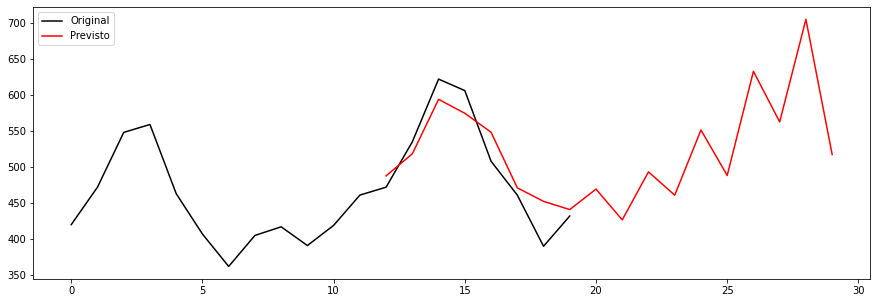

In [ ]:
H = 10
ordem = 12
amostra = st1[124:]

parametros = ajustar_ar(st1, [12])

previsoes = ar_recursivo(amostra, parametros, H)

fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(range(0, len(amostra)), amostra, c='black', label='Original')
ax.plot(range(ordem, len(amostra)+H), previsoes, c='red', label='Previsto')

plt.legend()

## Previsão Probabilística

## Média $\pm$ Variância

In [ ]:
def int_treinar_avaliar(dados, percentual, metodo_treino, metodo_inferencia, hiperparametros,ordem):
  # Tamanho dos dados
  n = len(dados)

  # Divisão Treino/Teste
  split = int(n * percentual)
  treino = dados[:split]
  teste = dados[split-ordem:]

  # Chama o método de treinamento do modelo
  parametros = metodo_treino(treino, hiperparametros)

  sigma = parametros[-1]

  # Calcula as previsões dentro da amostra
  previsoes_insample = metodo_inferencia(treino, parametros)

  # Calcular as previsões fora da amostra
  previsoes_outsample = metodo_inferencia(teste, parametros)

  fig, ax = plt.subplots(1, 1, figsize=(15, 7))

  ax.plot(range(0,n), dados, c='black')
  ax.vlines([split],[np.min(dados)],[np.max(dados)]) # Mostra onde começam os dados de treino
  
  for i in range(1,4):
    ax.fill_between(range(ordem,split), previsoes_insample - i*sigma, previsoes_insample + 2*sigma,
                    color='orange', alpha=.7 - (.2*i), label='{}$\sigma$ In Sample'.format(i))
    ax.fill_between(range(split, n), previsoes_outsample - i*sigma, previsoes_outsample + 2*sigma,
                    color='green', alpha=.7 - (.2*i), label='{}$\sigma$ Out Sample'.format(i))

  plt.legend()

In [ ]:
from scipy.stats import norm

def plot_prob(y, mu, sigma, ax):
  x = np.linspace(mu-3*sigma, mu+3*sigma, 35)
  probs = [norm.pdf(k, loc=mu, scale=sigma) for k in x]
  ax.vlines([y],[0],[np.max(probs)*1.3], color='red')
  ax.vlines([mu],[0],[np.max(probs)*1.3], color='blue')
  ax.plot(x,probs)

def prob_treinar_avaliar(dados, percentual, metodo_treino, metodo_inferencia, hiperparametros,ordem):
  # Tamanho dos dados
  n = len(dados)

  # Divisão Treino/Teste
  split = int(n * percentual)
  treino = dados[:split]
  teste = dados[split-ordem:]

  # Chama o método de treinamento do modelo
  parametros = metodo_treino(treino, hiperparametros)

  sigma = parametros[-1]

  ind_treino = np.linspace(0, split-ordem-1, 5)
  ind_teste = np.linspace(0, n-split-ordem-1, 5)

  # Calcula as previsões dentro da amostra
  previsoes_insample = metodo_inferencia(treino, parametros)

  # Calcular as previsões fora da amostra
  previsoes_outsample = metodo_inferencia(teste, parametros)

  fig, ax = plt.subplots(2, 5, figsize=(15, 5))

  for i in range(5):
    ix_treino = int(ind_treino[i])
    plot_prob(treino[ix_treino+ordem], previsoes_insample[ix_treino], sigma, ax[0][i])
    ax[0][i].set_title("t={}".format(ix_treino + ordem))
    ix_teste = int(ind_teste[i])
    plot_prob(teste[ix_teste+ordem], previsoes_outsample[ix_teste], sigma, ax[1][i])
    ax[1][i].set_title("t={}".format(split + ix_teste + ordem))

  ax[0][0].set_ylabel("In Sample")
  ax[1][0].set_ylabel("Out Sample")

  plt.tight_layout()

### Passageiros

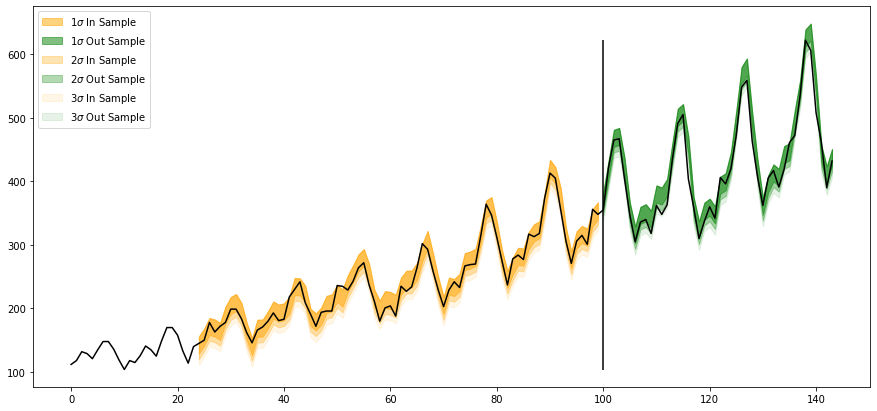

In [ ]:
int_treinar_avaliar(st1, .7, ajustar_arma, arma, [12,12], 24)

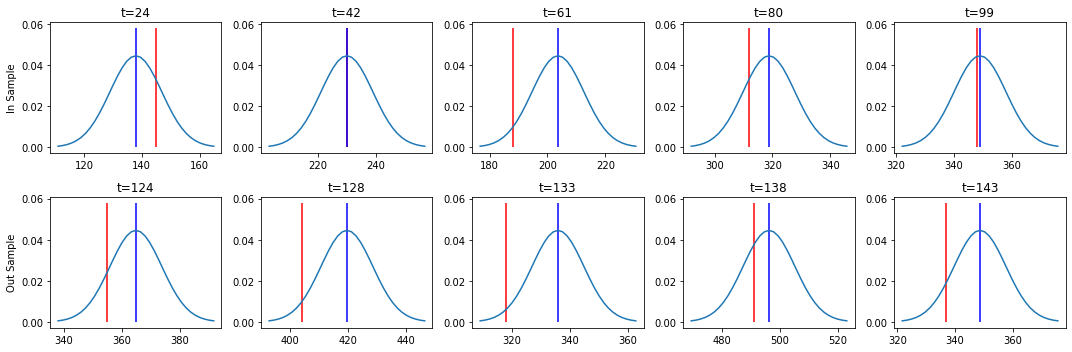

In [ ]:
prob_treinar_avaliar(st1, .7, ajustar_arma, arma, [12,12], 24)

### Dow Jones

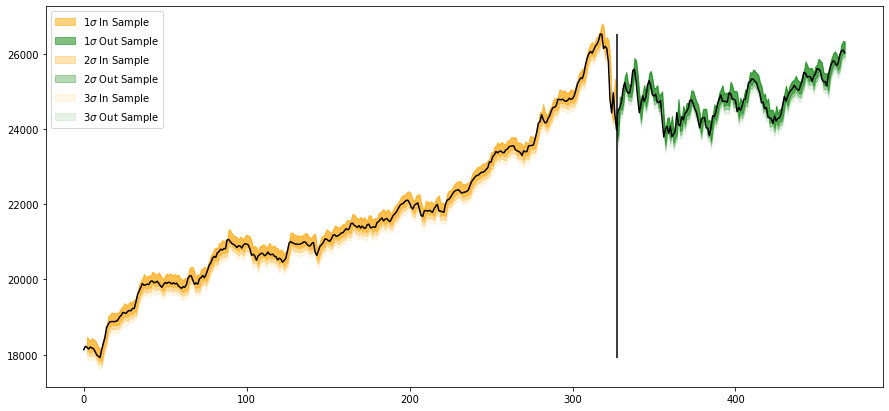

In [ ]:
int_treinar_avaliar(st2, .7, ajustar_arma, arma, [1,1], 2)

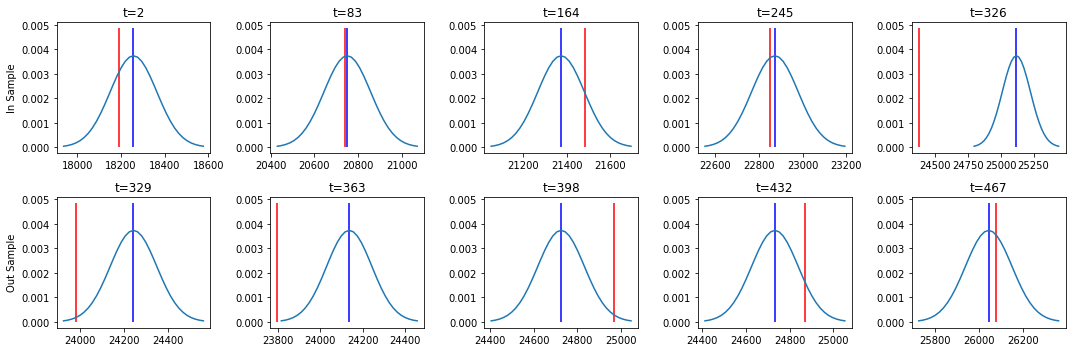

In [ ]:
prob_treinar_avaliar(st2, .7, ajustar_arma, arma, [1,1], 2)

## Previsão Intervalar

### Função Quantil

In [ ]:
def intervalo_interquantil(x, y, alfa, sigma, cor, ax):
  sup = [norm.ppf(1 - alfa/2, loc=k, scale=sigma) for k in y]
  inf = [norm.ppf(alfa/2, loc=k, scale=sigma) for k in y]
  ax.plot(x, inf, c=cor, label='$\\alpha=${}'.format(alfa))
  ax.plot(x, sup, c=cor)

def funcao_quantil(dados, percentual, metodo_treino, metodo_inferencia, hiperparametros,ordem):
  # Tamanho dos dados
  n = len(dados)

  # Divisão Treino/Teste
  split = int(n * percentual)
  treino = dados[:split]
  teste = dados[split-ordem:]

  # Chama o método de treinamento do modelo
  parametros = metodo_treino(treino, hiperparametros)

  sigma = parametros[-1]

  # Calcula as previsões dentro da amostra
  previsoes_insample = metodo_inferencia(treino, parametros)

  # Calcular as previsões fora da amostra
  previsoes_outsample = metodo_inferencia(teste, parametros)

  fig, ax = plt.subplots(1, 1, figsize=(15, 7))

  ax.plot(range(0,n), dados, c='black')
  ax.vlines([split],[np.min(dados)],[np.max(dados)]) # Mostra onde começam os dados de treino
  cores = ['lightblue','blue', 'purple']
  alfa = [.01, .1, .25]
  for i in range(3):
    intervalo_interquantil(range(ordem,split), previsoes_insample, alfa[i], sigma, cores[i], ax)
    intervalo_interquantil(range(split, n), previsoes_outsample, alfa[i], sigma, cores[i], ax)

  plt.legend()

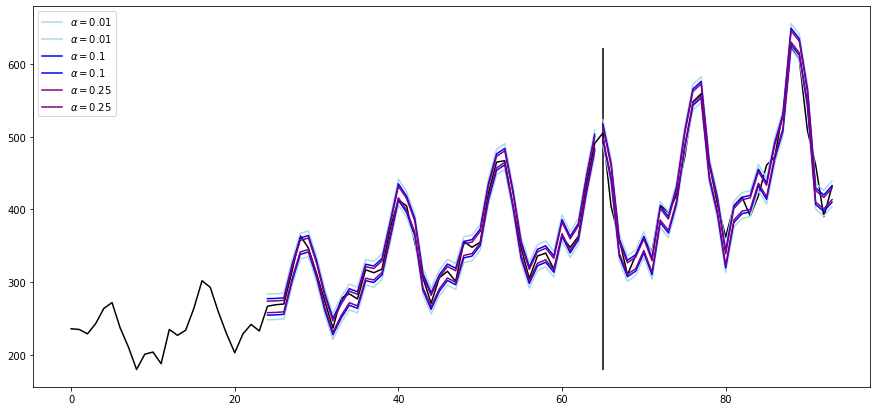

In [ ]:
funcao_quantil(st1[50:], .7, ajustar_arma, arma, [12,12], 24)

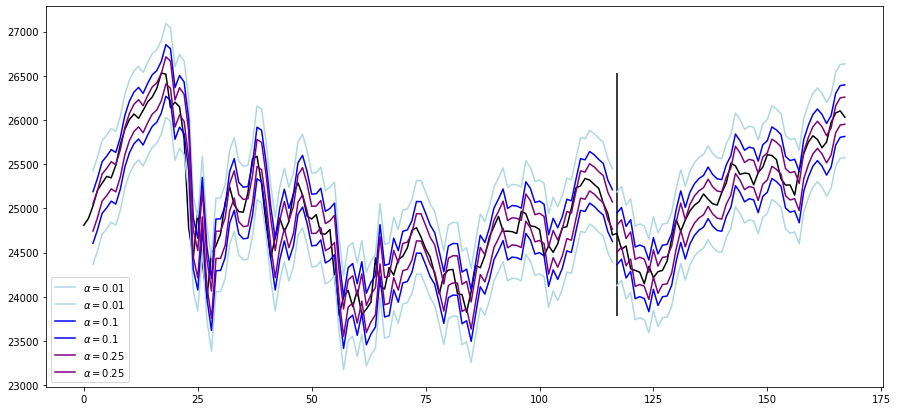

In [ ]:
funcao_quantil(st2[300:], .7, ajustar_arma, arma, [1,1], 2)

### Modelo ARCH(q)

In [ ]:
def ajustar_arch(residuos, parametros):
  r2 = residuos ** 2
  param = ajustar_ar(r2,parametros)
  return param

def arch(residuos, parametros):
  ordem = len(parametros[0])
  sigma = ar(residuos, parametros)
  return sigma

In [ ]:
def avaliar_arch(original, previsto, parametros):
  n = len(original)

  # Calculo os resíduos
  residuos = original - previsto
  
  # Ajustar um modelo ARCH(q) para esses resíduos
  coef = ajustar_arch(residuos, parametros)

  ordem = len(coef[0])
  
  # Prever o sigma² para cada média
  sigmas = arch(residuos, coef)

  fig, ax = plt.subplots(1,1, figsize=(15,5))

  ax.plot(original, c='black', label='Original')
  ax.plot(previsto, c='orange', label='Previsto')
  cores = ['purple','blue','lightblue']
  for i in range(1,4):
    ax.plot(range(ordem, n), previsto[ordem:] + i*sigmas, color=cores[i-1], label='{}$\sigma$'.format(i))
    ax.plot(range(ordem, n), previsto[ordem:] - i*sigmas, color=cores[i-1])
  plt.legend()

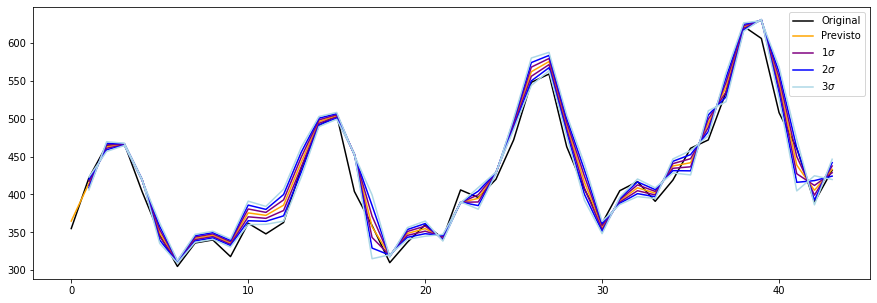

In [ ]:
# Ajustar um modelo para previsão do valor médio
parametros = ajustar_arma(st1[:100], [12,12])

# Fazer as previsões dos valores médios
previsoes = arma(st1[76:], parametros)

# Fazer as previsões das variâncias para cada valor médio
avaliar_arch(st1[100:], previsoes, [1])

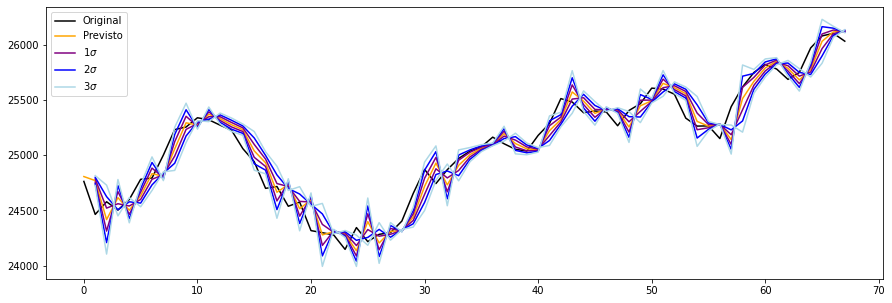

In [ ]:
parametros = ajustar_arma(st2[:400], [1,1])
previsoes = arma(st2[398:], parametros)
avaliar_arch(st2[400:], previsoes, [1])

## Previsão Intervalar e Probabilística para H=n

In [ ]:
def calcular_sigma(sigma, t, beta):
  return sigma * (t * beta)

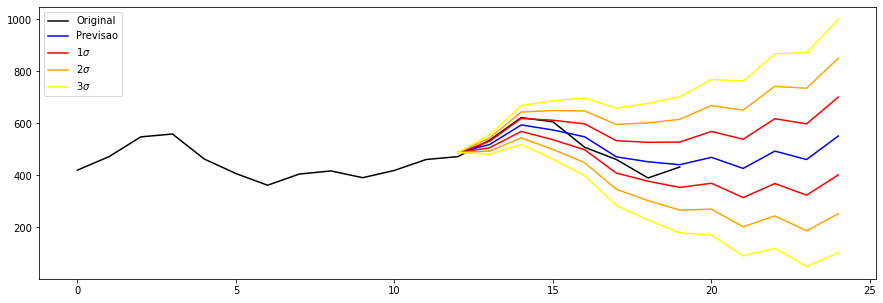

In [ ]:
H = 5
ordem = 24
amostra = st1[124:]

parametros = ajustar_arma(st1[100:], [12, 12])

previsoes = ar_recursivo(amostra, parametros, H)

fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(range(0, len(amostra)), amostra, c='black', label='Original')
ax.plot(range(ordem, len(amostra)+H), previsoes, c='blue', label='Previsao')

sigma = parametros[-1]

beta = 0.9

cores = ['red','orange', 'yellow']

for i in range(1, 4):
  inf = [y - i * calcular_sigma(sigma, t, beta) for t, y in enumerate(previsoes)]
  sup = [y + i * calcular_sigma(sigma, t, beta) for t, y in enumerate(previsoes)]
  ax.plot(range(ordem, len(amostra)+H), inf, c=cores[i-1], label='{}$\sigma$'.format(i))
  ax.plot(range(ordem, len(amostra)+H), sup, c=cores[i-1])

plt.legend()